In [400]:
from PIL import Image
import numpy as np
import open3d as o3d
from pdb import set_trace as bp
import random
import os
from tqdm import tqdm

In [119]:
index= 1

In [135]:
info_file = '/media/ivenwu/My_Disk/video_obj_sample/african_elephant_female/info/{:04d}.npz'.format(index)
image_path = '/media/ivenwu/My_Disk/video_obj_sample/african_elephant_female/{:04d}.png'.format(index)
mesh_path = '/media/ivenwu/My_Disk/video_obj_sample/african_elephant_female/frame_{:06d}.obj'.format(index)

In [136]:
info = np.load(info_file)
image = Image.open(image_path)
mesh = o3d.io.read_triangle_mesh(mesh_path)

[Open3D WARNING] Read PNG failed: unable to parse header.
[Open3D WARNING] Read PNG failed: unable to parse header.


### 写在PIFu里的那个从3D到2D的投影

In [10]:
intrin = info['intrinsic_mat']
extrin = info['extrinsic_mat']

calib = intrin.dot(extrin)

points = np.array(mesh.vertices)
points = points[:,[0,2,1]]
points[:,1]*= -1
ones_array = np.ones(points.shape[0])
homo_points = np.concatenate([points,ones_array.reshape(-1,1)],axis=1)

project = calib.dot(homo_points.T).T

In [48]:
re =recover_mat.dot(np.concatenate([project,np.ones((project.shape[0],1))],axis=1).T).T

### 将矩阵进行扩充，然后求逆，得到2d->3d的矩阵

In [11]:
intrin = np.eye(4)
intrin[:-1,:-1] = info['intrinsic_mat']
extrin = np.concatenate([extrin,np.array([0,0,0,1]).reshape(1,-1)],axis=0)
recover_mat = np.linalg.pinv(intrin.dot(extrin))

### 根据depth和image去重建

In [183]:
depth = info['depth_map']
# depth = recover_depth(image,info)
seg = info['segmentation_masks']

In [297]:
x,y = np.where(seg!=0)
co = np.concatenate([x.reshape(1,-1),y.reshape(1,-1)]).T
# random.sample(range(co.shape[0]),3)
# select_co = co[random.sample(range(co.shape[0]),5000)]
select_co = co
z = [depth[c[0],c[1]] for c in select_co]
z = np.array(z).reshape(-1,1)

xyz = np.concatenate([select_co*z,z],axis=1)
xyz = xyz[:,[1,0,2]]
xyz.shape

(84277, 3)

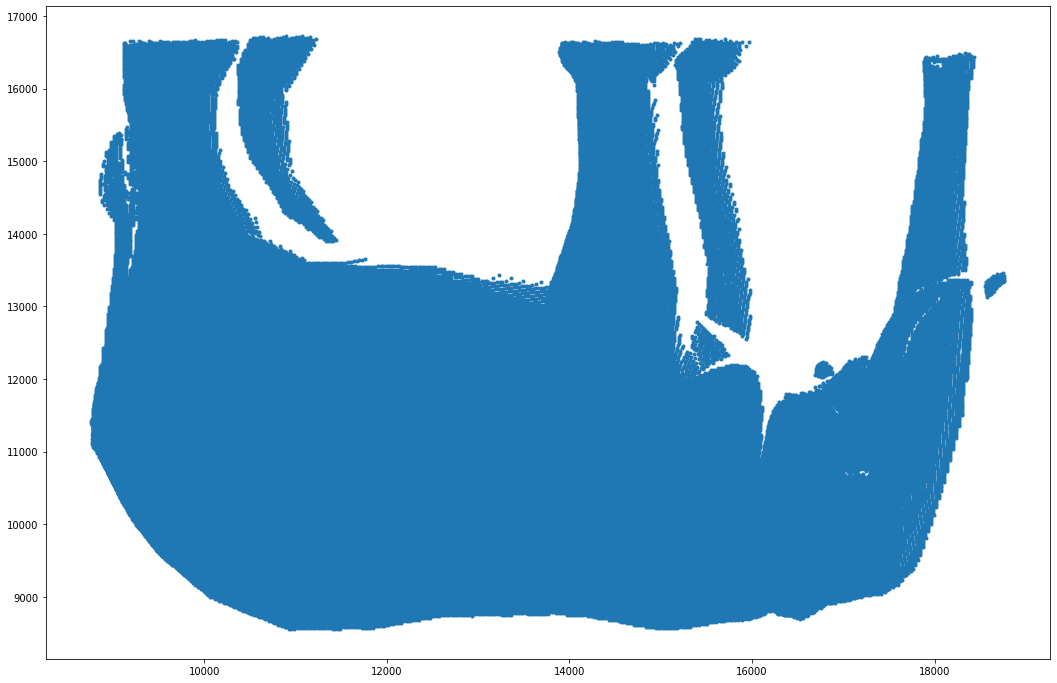

In [298]:
import matplotlib.pyplot as plt
plt.figure(figsize=(18,12))
plt.plot(xyz[:, 0], xyz[:, 1], '.')

In [299]:
### 拼接个1
xyzw = np.concatenate([xyz,np.ones((xyz.shape[0],1))],axis=1)
recon = recover_mat.dot(xyzw.T).T

recon = recon[:,:-1]
recon[:,1] *= -1
recon[:,-1] *= -1

recon.shape

(84277, 3)

In [300]:
def drawSphere(center, radius, color=[0.0,0.0,0.0]):
    mesh_sphere = o3d.geometry.TriangleMesh.create_sphere(radius=radius)
    transform_mat = np.eye(4)
    transform_mat[0:3, -1] = center
    mesh_sphere.transform(transform_mat)
    mesh_sphere.paint_uniform_color(color)
    return mesh_sphere

### Show points and mesh(comparison)

In [301]:
vis = o3d.visualization.Visualizer()
pcd = o3d.geometry.PointCloud()


pcd.points = o3d.utility.Vector3dVector(recon)
# pcd.points = o3d.utility.Vector3dVector(re[:,:-1])

mesh = o3d.io.read_triangle_mesh(mesh_path)

mesh_new_point = np.array(mesh.vertices)[:,[0,2,1]]
# mesh_new_point[:,1] *= -1
# mesh_new_point[:,0] *= -1


mesh_new_point[:,2] *= -1

# mesh_new_point[:]
mesh.vertices = o3d.utility.Vector3dVector(mesh_new_point)

mesh.paint_uniform_color([1, 0.706, 0])

sphere = drawSphere(center=[5,0,5],radius=1)
FOR1 = o3d.geometry.TriangleMesh.create_coordinate_frame(size=10, origin=[0, 0, 0])

o3d.visualization.draw_geometries([pcd,mesh,FOR1,sphere])

[Open3D WARNING] Read PNG failed: unable to parse header.
[Open3D WARNING] Read PNG failed: unable to parse header.


### Warping

In [380]:
mesh_path1 = '/media/ivenwu/My_Disk/video_obj_sample/african_elephant_female/frame_{:06d}.obj'.format(2)
mesh1_ori = o3d.io.read_triangle_mesh(mesh_path1)

[Open3D WARNING] Read PNG failed: unable to parse header.
[Open3D WARNING] Read PNG failed: unable to parse header.


In [381]:
flow = np.load('3dflow.npy')
flow.shape

(1024, 1024, 3)

100%|███████████████████████████████████████████| 99/99 [00:02<00:00, 44.02it/s]


In [395]:
select_flow = np.array([flow[select_single_co[0],select_single_co[1]] for select_single_co in select_co])
select_flow = select_flow[:,[1,0,2]]

select_flow[:,0] *= -1

# select_flow[:,-1] *= -1
# select_flow[:,2] *= -1
# select_flow = np.zeros(select_flow.shape)
after_points = recon + select_flow

In [397]:
pcd2 = o3d.geometry.PointCloud()
pcd2.points = o3d.utility.Vector3dVector(after_points)

mesh1 = o3d.io.read_triangle_mesh(mesh_path1)
mesh_new_point1 = np.array(mesh1.vertices)[:,[0,2,1]]
mesh_new_point1[:,2] *= -1
mesh1.vertices = o3d.utility.Vector3dVector(mesh_new_point1)
mesh1.paint_uniform_color([1, 0.706, 0])

FOR1 = o3d.geometry.TriangleMesh.create_coordinate_frame(size=10, origin=[0, 0, 0])
o3d.visualization.draw_geometries([pcd2,mesh1,FOR1])

[Open3D WARNING] Read PNG failed: unable to parse header.
[Open3D WARNING] Read PNG failed: unable to parse header.


## For the optimization

### load the first frame as base

In [404]:
flow_dir = '/home/ivenwu/下载/RAFT-3D-master/flow'
info_dir = '/media/ivenwu/My_Disk/video_obj_sample/african_elephant_female/info/'
image_dir = '/media/ivenwu/My_Disk/video_obj_sample/african_elephant_female'
mesh_path = '/media/ivenwu/My_Disk/video_obj_sample/african_elephant_female/frame_{:06d}.obj'.format(1)
# for single_flow in os.listdir(flow_dir):

info = np.load(os.path.join(info_dir,'0001.npz'))
intrin = np.eye(4)
intrin[:-1,:-1] = info['intrinsic_mat']
extrin = info['extrinsic_mat']
extrin = np.concatenate([extrin,np.array([0,0,0,1]).reshape(1,-1)],axis=0)
recover_mat = np.linalg.pinv(intrin.dot(extrin))

depth = info['depth_map']
seg = info['segmentation_masks']

x,y = np.where(seg!=0)
co = np.concatenate([x.reshape(1,-1),y.reshape(1,-1)]).T
select_co = co[random.sample(range(co.shape[0]),15000)]
# select_co = co
z = [depth[c[0],c[1]] for c in select_co]
z = np.array(z).reshape(-1,1)

xyz = np.concatenate([select_co*z,z],axis=1)
xyz = xyz[:,[1,0,2]]

xyzw = np.concatenate([xyz,np.ones((xyz.shape[0],1))],axis=1)
recon = recover_mat.dot(xyzw.T).T

recon = recon[:,:-1]
recon[:,1] *= -1
recon[:,-1] *= -1


    
    

In [ ]:
for flow_index in tqdm(range(1,100)):
    flow = np.load(os.path.join(flow_dir,'{}to{}.npy'.format(flow_index,flow_index+1)))
    info_file_base = os.path.join(info_dir,'{:04d}.npz'.format(flow_index))
    image_path_base = os.path.join(image_dir,'{:04d}.png'.format(flow_index))
        
    
#     info_base = np.load(info_file_base)
#     image_base = Image.open(image_path_base)
    
#     intrin_base = info_base['intrinsic_mat']
#     extrin_base = info_base['extrinsic_mat']
    
#     calib_base = intrin_base.dot(extrin_base)

### 对比project图的情况

In [ ]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(xyz)
FOR1 = o3d.geometry.TriangleMesh.create_coordinate_frame(size=10000, origin=[0, 0, 0])

pcd1 = o3d.geometry.PointCloud()
pcd1.points = o3d.utility.Vector3dVector(project)
pcd1.paint_uniform_color([1, 0.706, 0])
o3d.visualization.draw_geometries([pcd,pcd1,FOR1])

#### 乱七八糟的

In [ ]:
recon_p = recon[:,[0,2,1]]
recon_p[:,1] *= -1
r_ones = np.ones((recon_p.shape[0],1))
homo_r = np.concatenate([recon_p,r_ones],axis=1)

r_pro = calib.dot(homo_r.T).T

In [95]:
def recover_depth(image,info):
    INVALID_POINT = -1
    if type(image) !=np.ndarray:
        image = np.array(image)
    depth_ori = info['depth_map']
    intrin = info['intrinsic_mat']
    
    depth_new = np.zeros(depth_ori.shape)
    fx,fy,cx,cy = intrin[0,0],intrin[1,1],intrin[0,-1],intrin[1,-1]
    for x in range(image.shape[0]):
        a = (cx-x)/fx
        for y in range(image.shape[1]):
            b = (cy-y)/fy
            if depth_ori[x,y]!=INVALID_POINT:
                depth_new[x,y] = depth_ori[x,y] * np.linalg.norm([1,a,b])
    return depth_new        

In [26]:
depth_new = recover_depth(image,info)

In [28]:
depth_new

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [15.90887458, 15.90887553, 15.9088757 , ..., 15.90887271,
        15.90887255, 15.90887458],
       [15.89251302, 15.8925136 , 15.89251339, ..., 15.89251339,
        15.89251261, 15.89251302],
       [15.87618586, 15.87618807, 15.87618748, ..., 15.87618748,
        15.87618608, 15.87618686]])

In [58]:
dep = info['depth_map']
dep[np.where(info['segmentation_masks']==0)]=255
dep[dep!=255].min()

23.806984

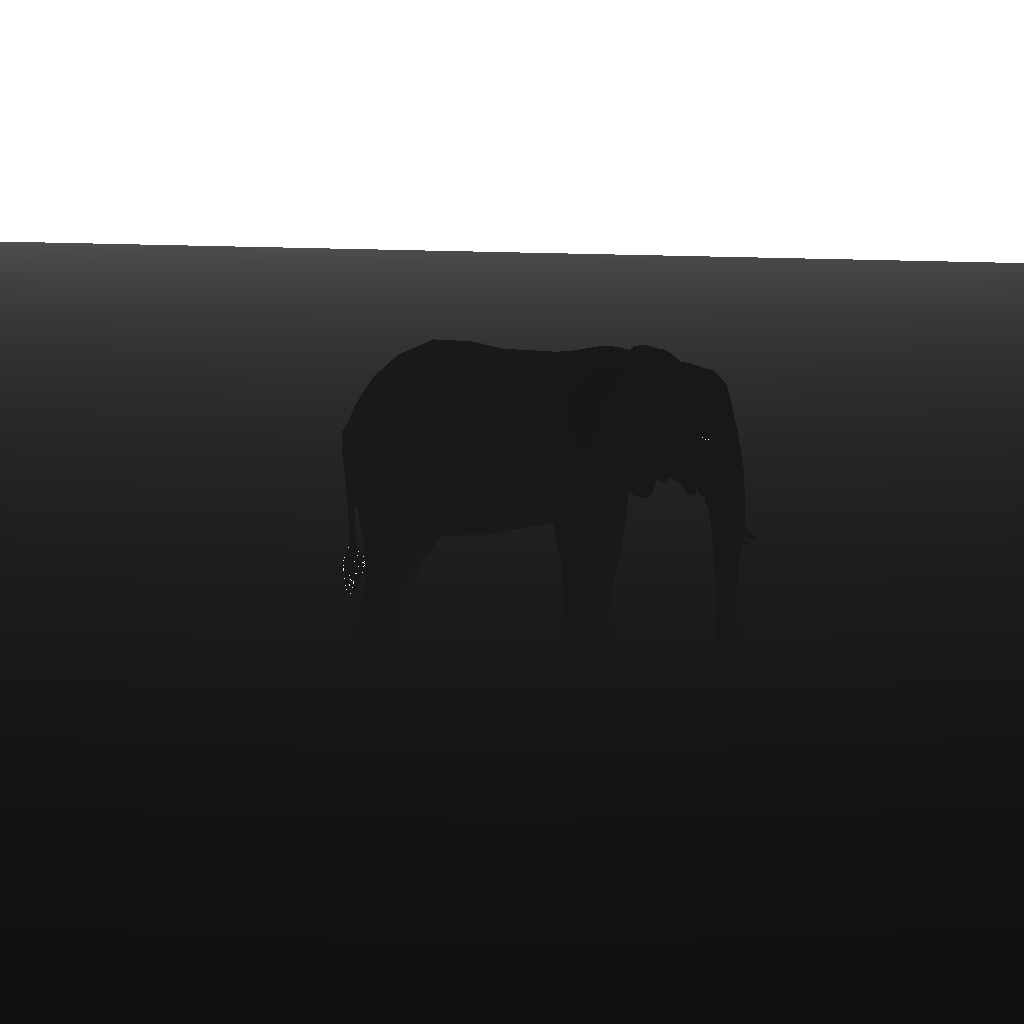

In [34]:
depth_ori = info['depth_map'].astype(np.uint8)
depth = Image.fromarray(depth_ori)
depth

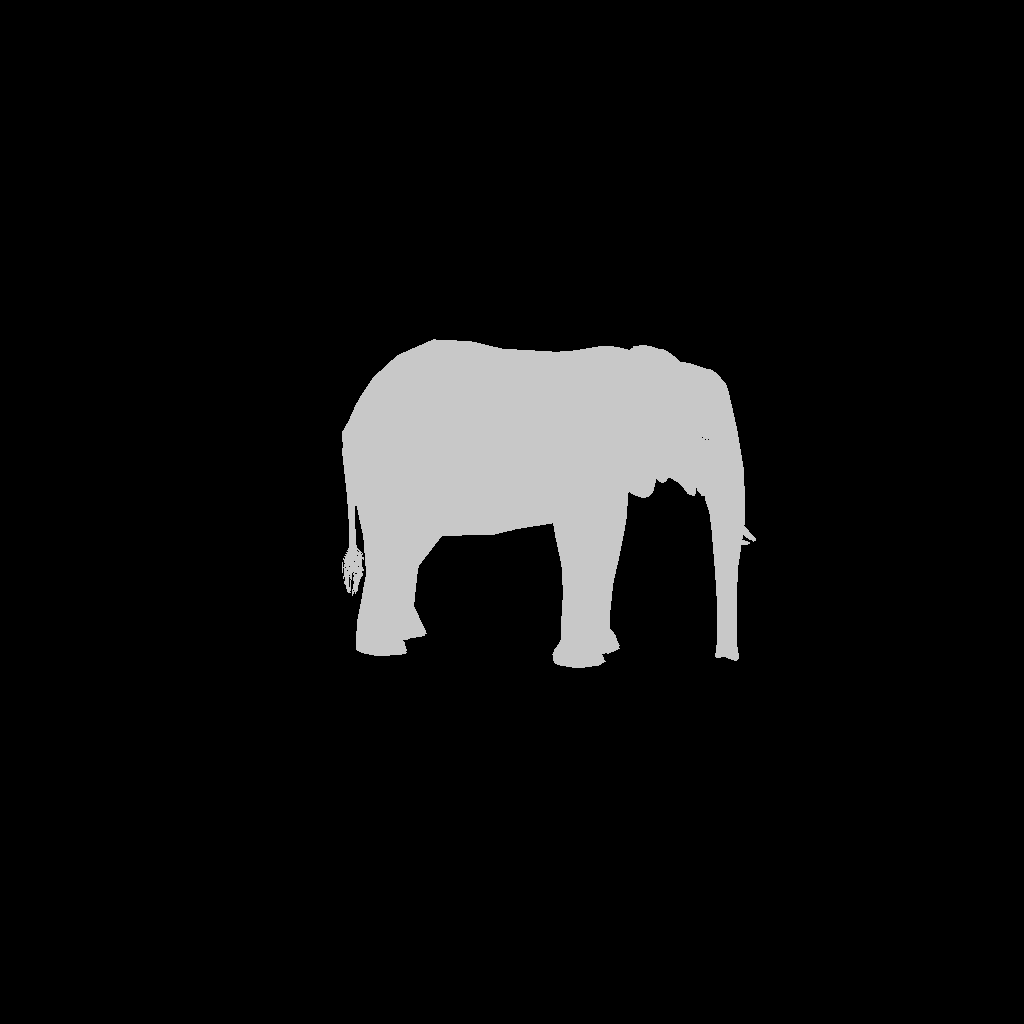

In [52]:
seg = info['segmentation_masks']
Image.fromarray(seg.astype(np.uint8))

In [ ]:
info